In [1]:
# TODO:
# we are assuming that it is deployed healthy.  and that new data has come in   and when bootstraping the splits are known (eliminate covariate shift), and when doing umap the splits dont matter
#.   -> therefore results are slightly optimisic and further feature engineering for the specific context should be done for the bridge
#.  but since we want ease of use to demonatrate this code for 18 separate cases we assumed a slight optimisim in the way the data is observed. In the practical setting to changes will be made (1) A covariate shift will be observed at the bootstrapping stage (2) Hyper-parameter optimisation must be applied for each individual bridge structure / with known sensor sampling rates etc
#   However since the purpose here was to demonstrate these two assumptions were placed on the data pipeline
# standard scalar only healthy --> assumes that when the structure is deployed it is healthy
# umap + hdbscan done globally and will grow with time
# bootstrap assumes perfect split / knowledge


# delete excess junk in folder before pushing
# comments / readme / writing / dont forget about the not starting from zero array
# 2. Have a re-think / re-check wrt data leakage
# 3. Comment on the functions in the module. Add more explanations here. Finish the README write up including library version.

# Imports

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from src import methodology, processing, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize']=[15, 10]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['font.size'] = '32'   # Use 22 if legend overlaps on data
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.autolayout'] = True

np.random.seed(0)
random.seed(0)

# Parameter Values

## Parameters for reading in data

Feel free to change any hyper-parameter setting as one likes, but only the following cases were explicitly verified to have worked *without* the need to change *any hyper-parameter*. 

- DSA_B09_DL50_P00 | DSA_B09_DL50_PA1 | DSA_B09_DL50_PA2
- DSA_B09_DL25_P00 | DSA_B09_DL25_PA1 | DSA_B09_DL25_PA2
- DSA_B15_DL50_P00 | DSA_B15_DL50_PA1 | DSA_B15_DL50_PA2
- DSA_B15_DL25_P00 | DSA_B15_DL25_PA1 | DSA_B15_DL25_PA2
- DSB_B09_DL50_P00 | DSB_B09_DL50_PA1 | DSB_B09_DL50_PA2
- DSB_B09_DL25_P00 | DSB_B09_DL25_PA1 | DSB_B09_DL25_PA2

In particular note that only vehcile type V1 was explicitly studied, so that DOF_NUM = 2 by default for all cases. 

In [3]:
DATA_ROOT_LOC = '../../../data/'            # Where data is located relative to current notebook file
NUM_DATA_IN_DIR = 800

Bridge_Type = 'DSA_B09'                      # B09 | B15 | B21 | B27 | B33 | B39
Damage_Location = 'DL50'                     # DL25 | DL50
Damage_Levels = ['DM00', 'DM20', 'DM40']     # DM00 ("Healthy") | DM20 | DM40
Vehicle_Type = 'V1'                          # V1 | V2 | V5
Bridge_Profile = 'P00'                       # P00 | PA1 | PA2

DOF_NUM = 2                                  # V1 has 2 DOF. Hardcoded because only V1 was investigated

# Select sampling rate of FFT depending on dataset type
# Further information on the difference between NFFT and 
# Fs is available at:
# https://www.bitweenie.com/listings/fft-zero-padding/
if Bridge_Type[0:3] == 'DSA':
    NFFT = 2**10
    Fs = 1024
elif Bridge_Type[0:3] == 'DSB':
    NFFT = 2**9
    Fs = 256

freqs = np.arange(0,NFFT/2)/NFFT*Fs


sample_times = 1000  # Number of over/under sampling for bootstrap-like procedure. Changing this effects density of final clusters

save_image = False   # Set to True if user wants to save image output of UMAP --> HDBSCAN

--------

-----------

----------

# Preprocessing Code

## Reading in Data

In [4]:
data = utils.read_data_fft(Bridge_Type, Damage_Location, Vehicle_Type, Bridge_Profile,
                    NUM_DATA_IN_DIR = NUM_DATA_IN_DIR , 
                    DATA_ROOT_LOC = DATA_ROOT_LOC, 
                    NFFT=NFFT)

Processed Event 50 from damage level DM00
Processed Event 100 from damage level DM00
Processed Event 150 from damage level DM00
Processed Event 200 from damage level DM00
Processed Event 250 from damage level DM00
Processed Event 300 from damage level DM00
Processed Event 350 from damage level DM00
Processed Event 400 from damage level DM00
Processed Event 450 from damage level DM00
Processed Event 500 from damage level DM00
Processed Event 550 from damage level DM00
Processed Event 600 from damage level DM00
Processed Event 650 from damage level DM00
Processed Event 700 from damage level DM00
Processed Event 750 from damage level DM00
Processed Event 800 from damage level DM00

Processed Event 50 from damage level DM20
Processed Event 100 from damage level DM20
Processed Event 150 from damage level DM20
Processed Event 200 from damage level DM20
Processed Event 250 from damage level DM20
Processed Event 300 from damage level DM20
Processed Event 350 from damage level DM20
Processed Ev

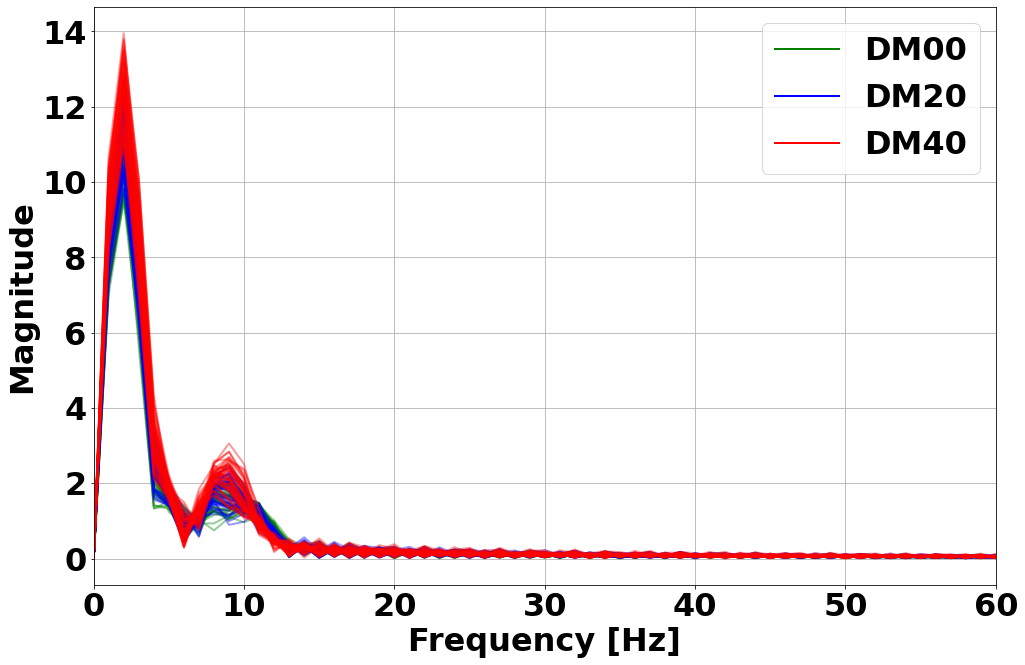

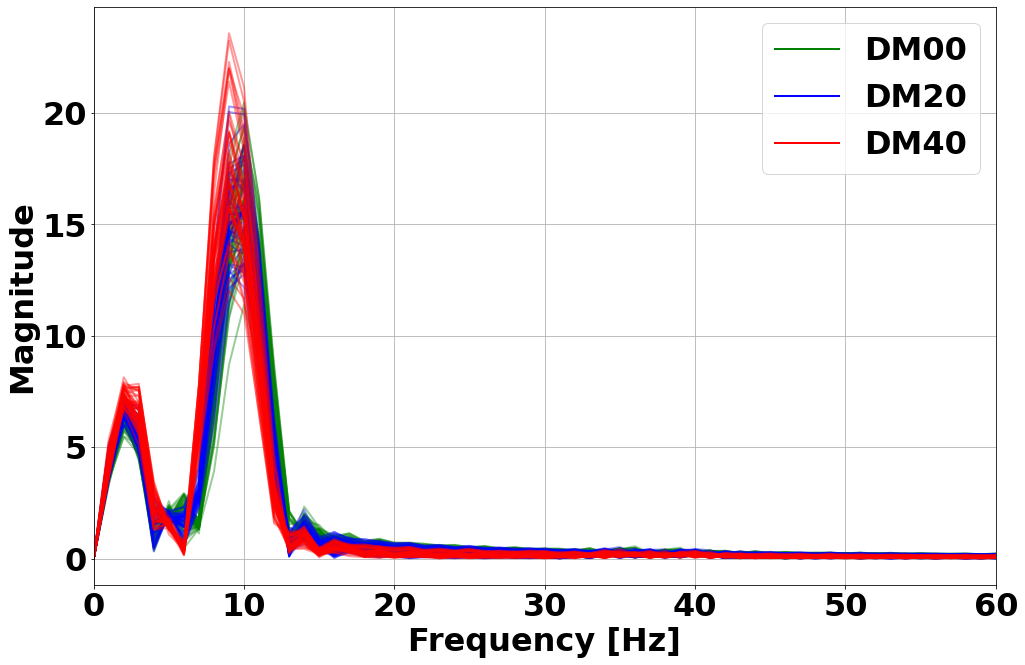

In [5]:
# Demonstraing howt he data looks after the FFT

plt_flag_data = True
for dof in range(DOF_NUM):
    
    if plt_flag_data:
        plt.figure()
        # If you intend to plot other parts further on
        # Then please ensure the following code *is* run. 
        # It helps with the labelling of the plot in a loop.
        #######################
        label_healthy = ['DM00'] 
        label_moderate = ['DM20']
        label_large = ['DM40']
        for i in range(1,50):
            label_healthy += [None]
            label_moderate += [None]
            label_large += [None]
        #########################

        # FFT only
#         plt.title(f'DOF NUMBER: {dof+1}')
        # We take columns 1 --> end, because there is a 'zero' occuring at index 0
        plt.plot(freqs[:], abs(data[dof]['DM00'][0:50,:].T),'g', alpha = 0.4, label = label_healthy);
        plt.plot(freqs[:], abs(data[dof]['DM20'][0:50,:].T),'b', alpha = 0.4, label = label_moderate);
        plt.plot(freqs[:], abs(data[dof]['DM40'][0:50,:].T),'r', alpha = 0.4, label = label_large);
        cols = abs(data[dof]['DM00'][:,1:].T).shape[1]


        plt.xlim([0,60]) # Cut Off Frequency
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

## Analyzing the effect of bootstraping 

It is assumed here that we know which data is DM00, DM20, DM40. This is for demonstration purposes, in the actual code, it won't be known which data is which. This is discussed in more details in the comments below.

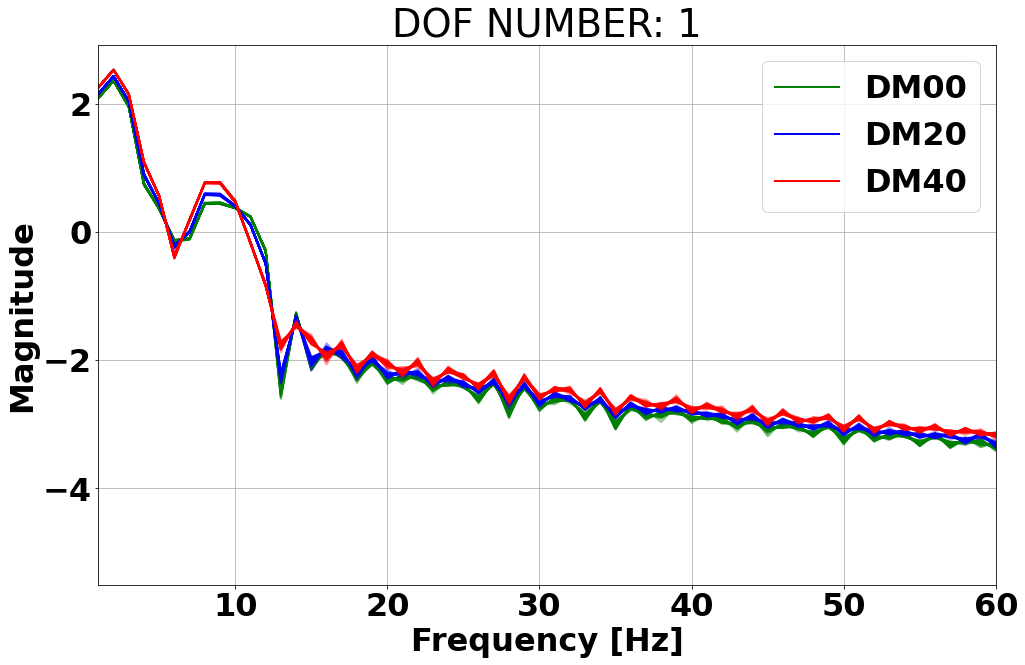

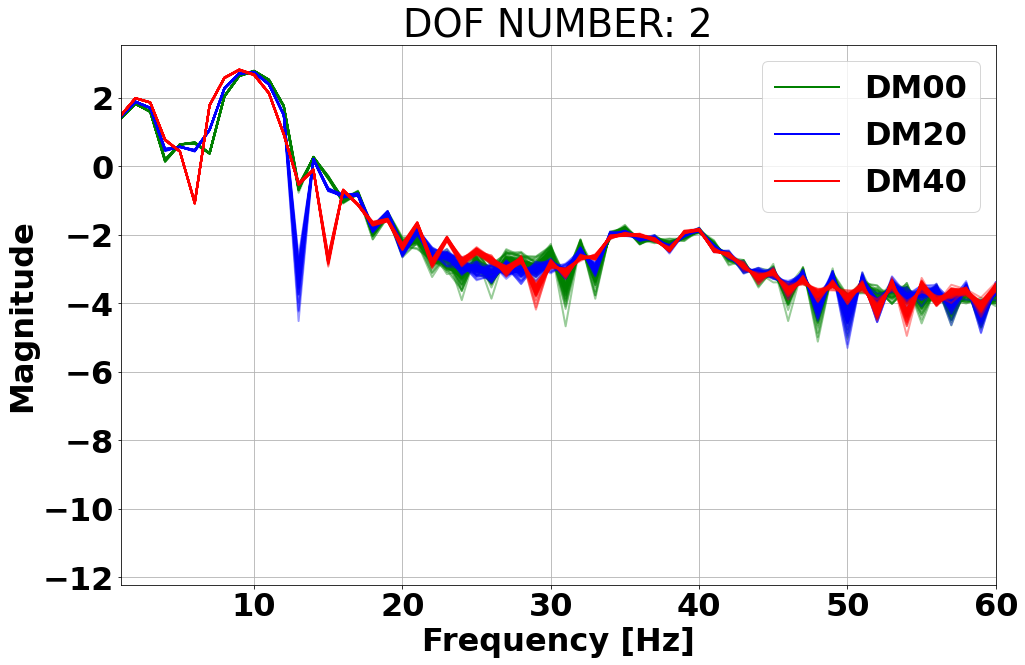

In [6]:
plt_flag_data = True

transformed = []
for dof in range(DOF_NUM):
    
    transformed.append({})
    if plt_flag_data:
        plt.figure()
        healthy_data_fft = data[dof]['DM00']
        mod_data_fft = data[dof]['DM20']
        large_data_fft = data[dof]['DM40']

        # PERFORM BOOTSTRAPPING
        # Notice that this is performed over the complex domain
        # Also notice: In order to tell when damage begins to appear one can program an alarm
        # such as a one class support vector machine (OCSVM). This has been demonstrated previously in:
        
        # Cheema, P., Alamdari, M. M., Chang, K. C., Kim, C. W., & Sugiyama, M. (2022). 
        # A drive-by bridge inspection framework using non-parametric clusters over projected data manifolds. 
        # Mechanical Systems and Signal Processing, 180, 109401.
        
        # Alternatively, in a practical setting it would be advisable to regularly pool data into separate
        # portions (400-800 sensor sampels) and then bootstrap over those portions, and observe shifts in the 
        # fft distribution. Here we just assume for simplicity, that we have X sensor samples, and "luckily" each
        # time we separate them, we have chanced upon a nice separation of DM00 --> DM20 --> DM40. However in 
        # a practical setting the transitions may look like DM00 --> [DM00,DM20] --> [DM20] --> [DM20, DM40] --> DM40
        # so that some overlaps may occur. Regardless, the presence of overlapping will show very strongly
        # in the proposed UMAP --> HDBSCAN data pipeline since the underlying distributions will have shifted.
        # i.e. a covariate shift will occur due to the inherent distance separations between damage states as seen
        # in the frequency domains
        healthy_bootstrap = processing.bootstrap_sampling(healthy_data_fft, sample_times=sample_times) 
        mod_bootstrap = processing.bootstrap_sampling(mod_data_fft, sample_times=sample_times) 
        large_bootstrap = processing.bootstrap_sampling(large_data_fft, sample_times=sample_times) 

        # Taking the log-abs(.) so we scale data + work in real domain
        healthy_log_abs_train = processing.log_abs_transform(healthy_bootstrap[0])
        mod_log_abs_train = processing.log_abs_transform(mod_bootstrap[0])
        large_log_abs_train = processing.log_abs_transform(large_bootstrap[0])

        plt.title(f'DOF NUMBER: {dof+1}')
        plt.plot(freqs[1:], healthy_log_abs_train[0:50,1:].T,'g', label = label_healthy, alpha = 0.4);
        plt.plot(freqs[1:], mod_log_abs_train[0:50,1:].T,'b', label = label_moderate, alpha = 0.4);
        plt.plot(freqs[1:], large_log_abs_train[0:50,1:].T,'r', label = label_large, alpha = 0.4);
        plt.xlim([freqs[1],60])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')

        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
        # We take a little bit of an offset from zero to avoid the impacts of log(small_value) which occur
        # near 0 Hz
        transformed[dof]['DM00'] = healthy_log_abs_train[:,3:]
        transformed[dof]['DM20'] = mod_log_abs_train[:,3:]
        transformed[dof]['DM40'] = large_log_abs_train[:,3:]

## Demonstration of Standard Scaling effect

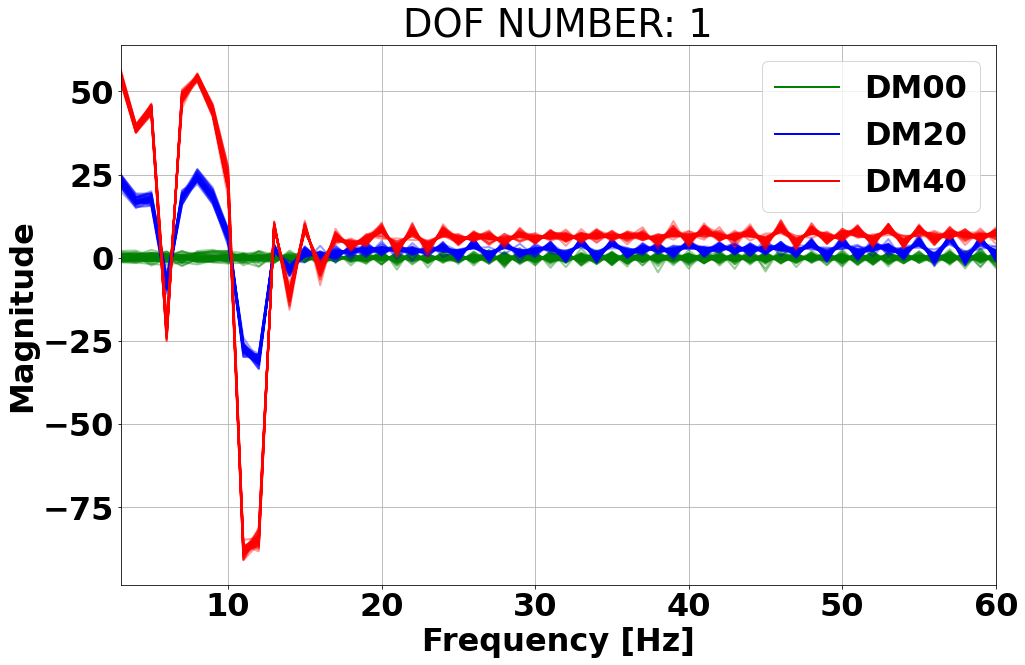

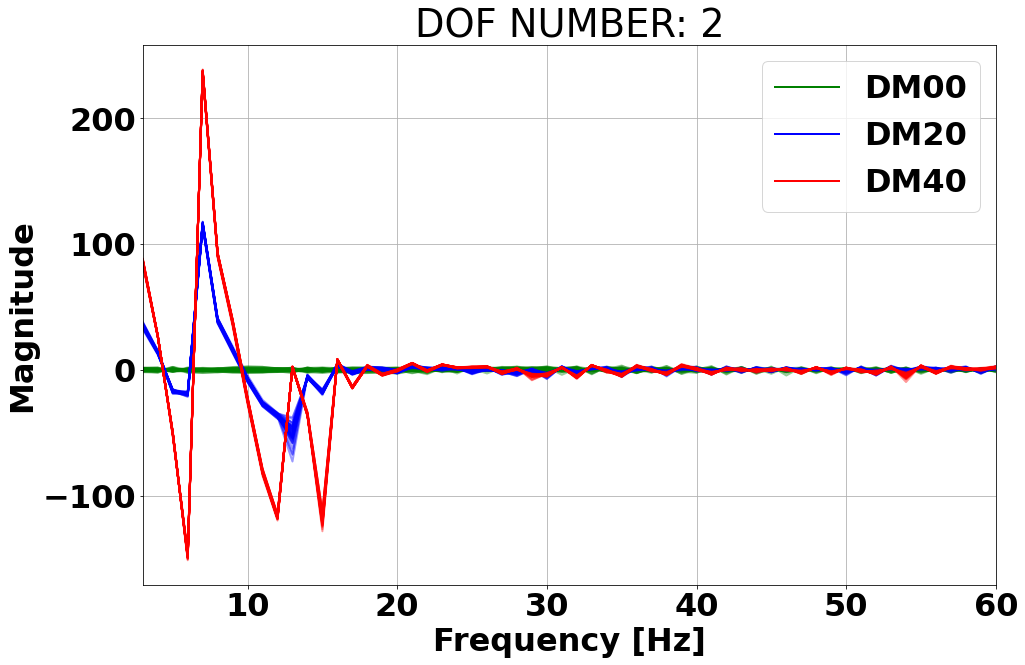

In [7]:
plt_flag_data = True
scaled = []

for dof in range(DOF_NUM):
    
    scaled.append({})
    if plt_flag_data:
        plt.figure()
        scaler = StandardScaler()
        # Making sure to fit only to the observed healthy data
        # Standard scaling tries to further push for separation between the damage cases
        healthy_scaled = scaler.fit_transform(transformed[dof]['DM00']) #### You NEED TO MAKE SURE THIS SPLIT IS CONSISTENT E.G. WHEN INPUTING THE DATASTREAMS SEQUENCING
        mod_scaled = scaler.transform(transformed[dof]['DM20'])
        large_scaled = scaler.transform(transformed[dof]['DM40'])
        
        plt.title(f'DOF NUMBER: {dof+1}')
        plt.plot(freqs[3:], healthy_scaled[0:50,:].T,'g', label = label_healthy, alpha = 0.4);
        plt.plot(freqs[3:], mod_scaled[0:50,:].T,'b', label = label_moderate, alpha = 0.4);
        plt.plot(freqs[3:], large_scaled[0:50,:].T,'r', label = label_large, alpha = 0.4);

        plt.xlim([freqs[3],60])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')

        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
           
        # Note: We displayed up until 60Hz, but we take the first 100 Hz in the data pipeline
        scaled[dof]['DM00'] = healthy_scaled[:,:100]
        scaled[dof]['DM20'] = mod_scaled[:,:100]
        scaled[dof]['DM40'] = large_scaled[:,:100]

------

-------

------

# Running UMAP $\rightarrow$ HDBSCAN Algorithm

This is to be run on the *transformed* data as per above. In this code it therefore assumes that all plots are run (because the data is pre-processing in each instance).

Note also that this function takes n_healty, n_mod, and n_large as inputs. It must be stressed that *these are not used* in the algorithm -- they are simply there to assist in the colors when plotting. The only input ever being using is that of the *total stacked data*.

Looking at the previous scaling, the ```fit-transform``` was perform directly on the healthy, and the ```transform``` on the modeerate (DM20), and then large (DM40) cases. This may initially come across as a data leakage problem, but in fact this is not the case. Because we operate under the assumption that the first X amount of days / weeks / months, the bridge should be operating within a healthy state, and therefore it is OK to perform a fit-transform here. From there-onwards, it is appropriate to continually apply the t```ransform``` only regardless of the health state (because if it is still healthy, the data will map to the same space, and if it contains damage, it will map to a different location). 

This option can be explored through a hyperparameter in the ```HDBSCAN_UMAP_Application``` function via ```total_obs```. This hyperparameter works to partition the stacked data into distinct observation sets e.g. by default ```total_obs=2```, so we assume that the total data stack is split into two, so the first half will contain DM00 and DM20 data, whilst the second half will contain a mixture of DM20, and DM40 data. 

In a practical implementation, the scalar transformations *should* be more ideally performed within the ```HDBSCAN_UMAP_Application``` function (transform the data live -- as it is being received) but for the sake of demonstration (i.e. clearly separating out the steps), this has been externalized from the function in the above step.

Note that even though there are 400 data in directory, beacuse we are over sampling (using the boot-strap like procedure) the ```n_healthy```, ```n_mod```, ```n_large``` will be the same as the ```sample_times``` chosen. 

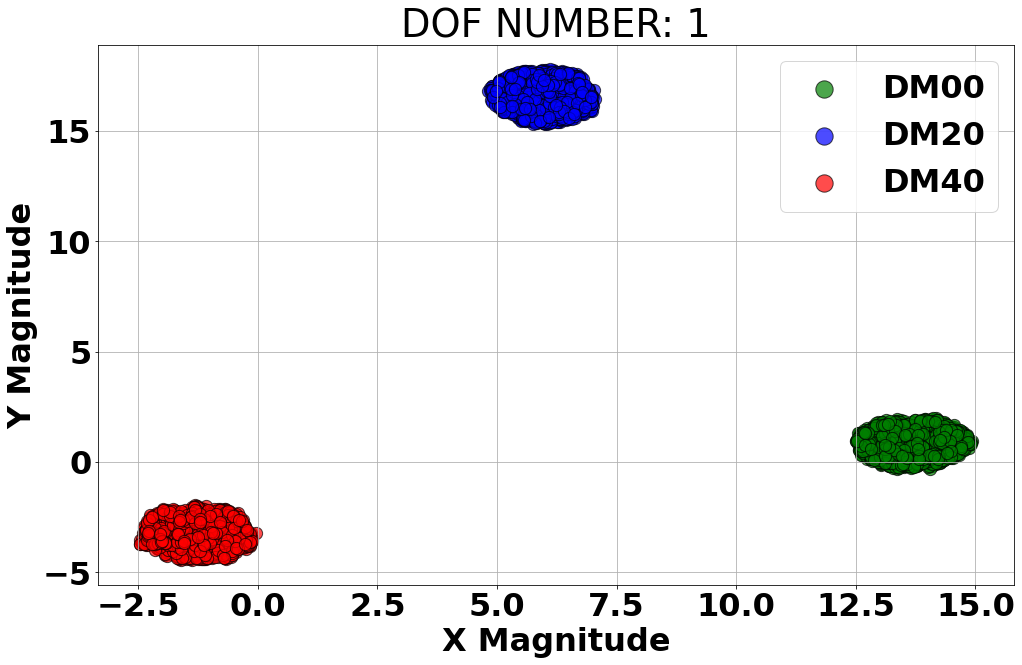

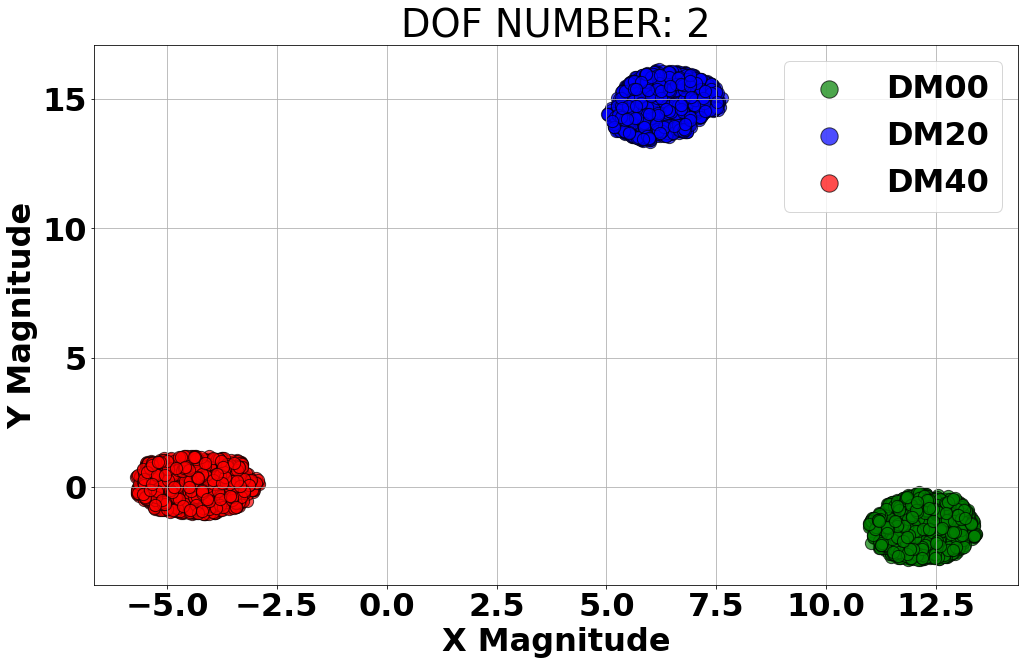

In [8]:
n_healthy, n_mod, n_large = sample_times, sample_times, sample_times
figs = []
for dof in range(DOF_NUM):
    # Stacking the observed data wrt current dof
    total_data = np.vstack((scaled[dof]['DM00'], scaled[dof]['DM20'], scaled[dof]['DM40']))
    # Apply UMAP --> HDBSCAN pipeline
    [_,_,aFig] = methodology.HDBSCAN_UMAP_Application(total_data, n_healthy, n_mod, n_large, dof, 
                                                      plot_flag = True)
    # Store figure files in a list so can be saved later
    figs.append(aFig) 

Note that it is also possible to check the results obtained by the proposed procedure against theoretical results. That is, by performing the UMAP projection *only*, and then assigning a color to each row, with the knowledge that *we know* which cluster each row belongs to. This can be achieved using the following code. 

This time instead however, we shall set the ```total_obs``` value to 5. In other words, our stack of data arrives to us in 5 discrete increments / time observations. 

Note also that the UMAP embeddings between the ```theoretical_clustering``` and ```HDBSCAN_UMAP_Application``` functions may not always necessarily be to the same locations, since the random seed slightly changes as we move from one function on to the next. What's important however, is that if separability exists in one function, it should also exist in the other function. 

# Save image to file location (optional)

In [9]:
if save_image == True:
    # Create path for new directory
    path_img = f'./images/{Bridge_Type}_{Damage_Location}_{Bridge_Profile}_NFFT--{NFFT}'
    # Check if nominated path exists
    utils.mkdir_p(path_img)
    # Save each figure
    figs[0][0].savefig('{}/DOF_{}.png'.format(path_img,1))
    figs[1][0].savefig('{}/DOF_{}.png'.format(path_img,2))